No duplicates found
 
 Signals to use for training: 
['X240_S110', 'X250_S110', 'X400_S200', 'X210_S70', 'X1000_S500', 'X245_S50', 'X600_S70', 'X1000_S70', 'X250_S100', 'X500_S110', 'X1000_S200', 'X750_S500', 'X750_S400', 'X1000_S170', 'X400_S70', 'X1000_S300', 'X400_S110', 'X225_S30', 'X300_S110', 'X500_S200', 'X750_S110', 'X675_S400', 'X1000_S400', 'X400_S250', 'X750_S170', 'X350_S170', 'X185_S30', 'X500_S70', 'X950_S90', 'X240_S100', 'X600_S40', 'X750_S300', 'X600_S300', 'X875_S200', 'X750_S70', 'X220_S90', 'X600_S400', 'X245_S90', 'X225_S70', 'X200_S70', 'X225_S50']

 Signals to hold for testing: 
['X245_S70', 'X750_S200', 'X500_S300', 'X600_S110', 'X200_S90', 'X400_S170X300_S70', 'X600_S170', 'X205_S50', 'X300_S70']

 Unused signals: 
['X400_S30', 'X500_S30', 'X205_S30', 'X300_S30', 'X500_S170', 'X170_S30', 'X400_S170', 'X180_S50', 'X245_S30', 'X190_S50']
# signals used for training =  41
Batch size =  64


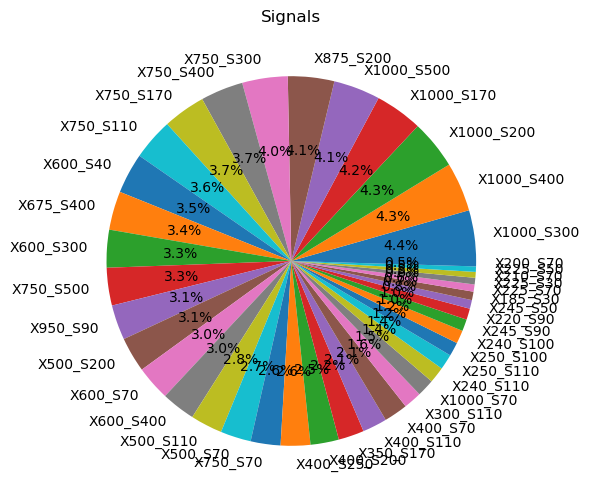

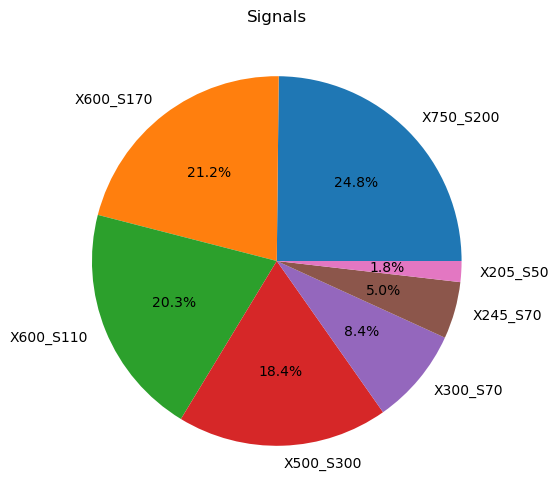

In [1]:
from helpers import duplicates, load_data, torch_loader
from plotting import GetFractions, PlotPNN 
# plotting
import matplotlib.pyplot as plt


# load

ignore_list = ['X400_S170', 'X500_S170', 'X170_S30', 'X245_S30', 'X205_S30', 'X400_S30', 'X500_S30', 'X300_S30', 'X180_S50', 'X190_S50']

blind_signals = ['X245_S70', 'X750_S200', 'X500_S300', 'X600_S110', 'X200_S90', 'X400_S170' 'X300_S70', 'X600_S170',  'X205_S50','X300_S70']

#data, hold_data = load_data("data.parquet", not_use_list=ignore_list)

data, hold_data = load_data("data.parquet", exclude_list = blind_signals, not_use_list=ignore_list)

seen_signals = set(data['signal'])

print("# signals used for training = ", len(seen_signals))

batch_size = 64#len(seen_signals)*64*5

print("Batch size = ", batch_size)

GetFractions(data)

GetFractions(hold_data)

'''
for s in set(data['signal']):
    mX = int(s.split("_")[0].split("X")[-1])
    mS = int(s.split("_")[1].split("S")[-1])

    PlotPNN(data, mX, mS)

'''

# Define features and context variables
features = ["PNN_score"] # The distribution you want to learn
context = ["real_mX", "real_mS"] # These are your conditional parameters

train_loader, val_loader, feature_scaler, context_scaler = torch_loader(data, features, context, batch_size=batch_size)


In [2]:
def count(loader, mX, mS):
    for i, batch in enumerate(loader):
        data, labels = batch
        count = 0
        for j in labels:
            if (int(j[0]) == mX) and (int(j[1]) == mS):
                count +=1
        print("mX = ", mX, " and mS = ", mS, " -> ", count, " events")
    
        break
    return 

print("\n Signal events in training set \n ")
for s in seen_signals:
    mX = int(s.split("_")[0].split("X")[-1])
    mS = int( s.split("_S")[-1])
    
    count(train_loader, mX, mS)

print("\n Signal events in validation set \n")
for s in seen_signals: #set(hold_data['signal']):
    mX = int(s.split("_")[0].split("X")[-1])
    mS = int( s.split("_S")[-1])
    
    count(val_loader, mX, mS)




 Signal events in training set 
 
mX =  240  and mS =  110  ->  2  events
mX =  250  and mS =  110  ->  0  events
mX =  400  and mS =  200  ->  1  events
mX =  210  and mS =  70  ->  0  events
mX =  1000  and mS =  500  ->  2  events
mX =  245  and mS =  50  ->  0  events
mX =  600  and mS =  70  ->  3  events
mX =  1000  and mS =  70  ->  1  events
mX =  250  and mS =  100  ->  0  events
mX =  500  and mS =  110  ->  0  events
mX =  1000  and mS =  200  ->  1  events
mX =  750  and mS =  500  ->  2  events
mX =  750  and mS =  400  ->  3  events
mX =  1000  and mS =  170  ->  3  events
mX =  400  and mS =  70  ->  0  events
mX =  1000  and mS =  300  ->  2  events
mX =  400  and mS =  110  ->  2  events
mX =  225  and mS =  30  ->  0  events
mX =  300  and mS =  110  ->  1  events
mX =  500  and mS =  200  ->  1  events
mX =  750  and mS =  110  ->  5  events
mX =  675  and mS =  400  ->  3  events
mX =  1000  and mS =  400  ->  6  events
mX =  400  and mS =  250  ->  4  events
mX = 

In [3]:
# network
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torchvision.utils import save_image
import torchvision
import torch.optim as optim

label_dim = 0 # not conditional

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, label_dim, hidden_dim=400):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc32 = nn.Linear(hidden_dim, latent_dim)  # Log-variance

    def forward(self, x, labels):
        #x = torch.cat([x, labels], dim=1)
        h1 = F.relu(self.fc1(x))
        h2 =  F.relu(self.fc2(h1))
        mu =  self.fc31(h2)
        logvar = self.fc32(h2)
        logvar = torch.clamp(logvar, max=30)  # Choose limits based on your specific needs
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim, label_dim, output_dim=1, hidden_dim=400):
        super(Decoder, self).__init__()
        self.fc4 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, output_dim)       # Predict the mean
        self.fc_logvar = nn.Linear(hidden_dim, output_dim)  # Predict the log-variance

    def forward(self, z, labels):
        #z = torch.cat([z, labels], dim=1)
        h4 = F.relu(self.fc4(z))
        h5 = F.relu(self.fc5(h4))
        mu = self.fc_mu(h5)  # Mean of the distribution (no sigmoid) 
        logvar = self.fc_logvar(h5)  # Log-variance of the distribution
        #logvar = torch.clamp(logvar, min=-30, max=30)  # Choose limits based on your specific needs

        return mu, logvar
 #torch.sigmoid(raw_output) #torch.clamp(raw_output, min=0.0, max=1.0)  #torch.sigmoid(raw_output))

class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, label_dim, hidden_dim=400):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, label_dim, hidden_dim=400)
        self.decoder = Decoder(input_dim, latent_dim, label_dim, hidden_dim=400)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, log_var = self.encoder(x, labels)
        z = self.reparameterize(mu, log_var)
        recon_mu, recon_log_var = self.decoder(z, labels) # for gaussian loss in NLL
        #recon_mu = self.decoder(z, labels) # for bernoulli loss in NLL

        return recon_mu, recon_log_var, mu, log_var
        #return recon_mu, mu, log_var

def bernoulli_nll_loss(x, mu):
    # Compute the negative log likelihood for a Bernoulli distribution
    nll = -torch.sum(x * torch.log(mu + 1e-6) + (1 - x) * torch.log(1 - mu + 1e-6), dim=1)  # sum over features
    return torch.mean(nll)  # mean over batch

def nll_loss(recon_mu, recon_logvar, x):
    """
    Compute the Negative Log-Likelihood (NLL) loss for Gaussian outputs.

    Args:
        recon_mu (torch.Tensor): Predicted mean of the Gaussian (decoder output).
        recon_logvar (torch.Tensor): Predicted log-variance of the Gaussian (decoder output).
        x (torch.Tensor): Ground truth data.

    Returns:
        torch.Tensor: NLL loss.
    """
    recon_var = torch.exp(recon_logvar)  # Variance = exp(log-variance)
    
    nll = 0.5 * torch.sum(recon_logvar + ((x - recon_mu) ** 2) / (recon_var + 0.00001))
    return nll

#def loss_function(recon_x, x, mu, log_var, beta=1.0):
def loss_function(recon_mu, recon_logvar, x, mu, log_var, beta=1.0):

    #reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')
    reconstruction_loss = nll_loss(recon_mu, recon_logvar, x)
    #reconstruction_loss = bernoulli_nll_loss(recon_mu, x) # variance is no longer needed

    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + beta * kl_divergence

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = abs(val_loss)  # Assuming val_loss can be negative; otherwise, just use val_loss directly.

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  # Changed to look for a decrease in loss
            self.best_score = score
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.epochs_no_improve} out of {self.patience}')
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True


In [4]:
import numpy as np
import pandas as pd


def generate_and_plot(df, model, labels, latent_dim, n_events = 1000):
    
    z = torch.randn(100, latent_dim).to(device)  # Adjust latent_dim to 30
    label_tensor = torch.tensor(np.tile(labels, n_events).reshape(n_events, 2)).to(device)
                              
    # Generate signal
    signal = generate_samples(model, z, label_tensor).to("cpu").detach().numpy()

    custom = np.linspace(0, 1, 20)

    if not df.empty:
        filtered_df = df[(df['real_mX'] == labels[0]) & (df['real_mS'] == labels[1])]
        plt.hist(filtered_df["PNN_score"][:len(signal)], alpha=0.7, density=True, bins=custom, label = "real")

    plt.hist(signal, alpha=0.7, density=True, bins=custom, label = "fake")
    plt.ylabel('Arbitrary units')
    plt.title('Distribution to learn')
    plt.xlim(0, 1)  # Force x-axis range to [0, 1]
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)


Epoch: 1 - Current Learning Rate: 1e-06
====> Epoch: 1 Average training (validation) loss: 0.1484 (-0.3546)
Epoch: 2 - Current Learning Rate: 1e-06
====> Epoch: 2 Average training (validation) loss: -0.6187 (-0.8267)


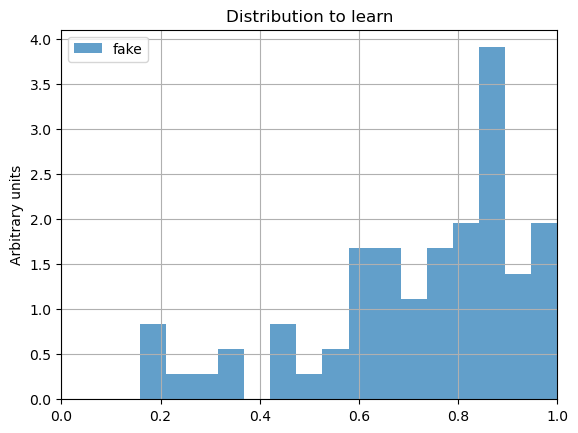

Epoch: 3 - Current Learning Rate: 1e-06
====> Epoch: 3 Average training (validation) loss: -0.9303 (-0.9897)
Epoch: 4 - Current Learning Rate: 1e-06
====> Epoch: 4 Average training (validation) loss: -1.0290 (-1.0545)


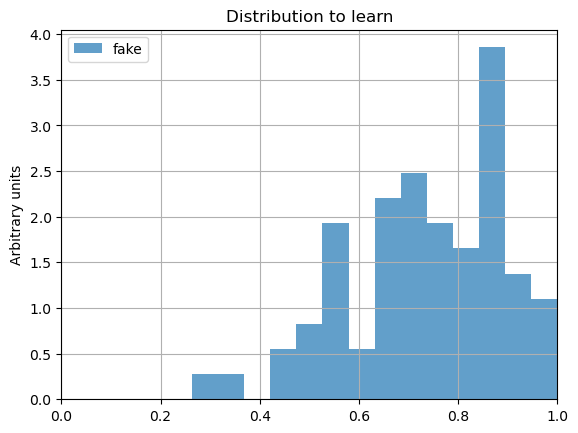

Epoch: 5 - Current Learning Rate: 1e-06
====> Epoch: 5 Average training (validation) loss: -1.0728 (-1.0846)
Epoch: 6 - Current Learning Rate: 1e-06
====> Epoch: 6 Average training (validation) loss: -1.0940 (-1.1045)


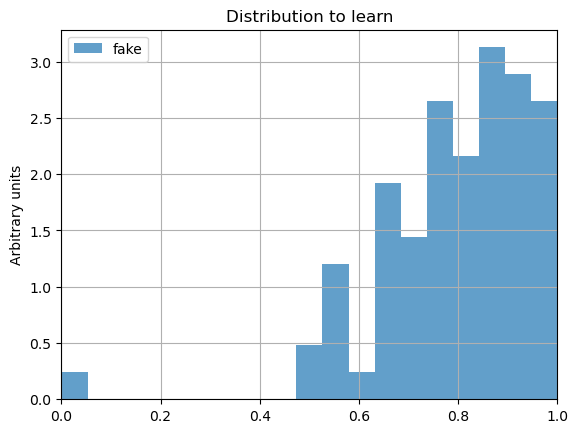

Epoch: 7 - Current Learning Rate: 1e-06
====> Epoch: 7 Average training (validation) loss: -1.1058 (-1.1052)
Epoch: 8 - Current Learning Rate: 1e-06
====> Epoch: 8 Average training (validation) loss: -1.1135 (-1.1100)


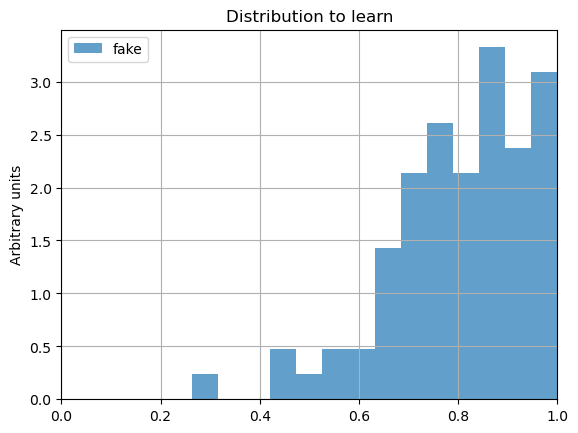

Epoch: 9 - Current Learning Rate: 1e-06
====> Epoch: 9 Average training (validation) loss: -1.1179 (-1.1164)
Epoch: 10 - Current Learning Rate: 1e-06
====> Epoch: 10 Average training (validation) loss: -1.1195 (-1.1217)


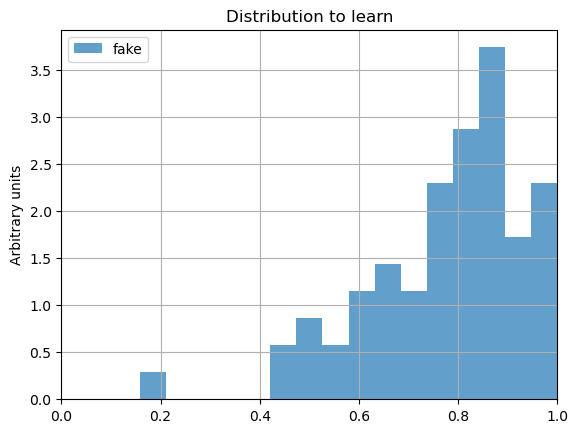

Epoch: 11 - Current Learning Rate: 1e-06
====> Epoch: 11 Average training (validation) loss: -1.1266 (-1.1157)
Epoch: 12 - Current Learning Rate: 1e-06
====> Epoch: 12 Average training (validation) loss: -1.1291 (-1.1326)


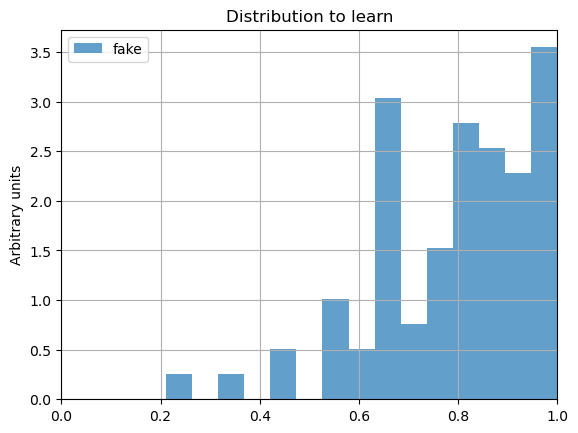

Epoch: 13 - Current Learning Rate: 1e-06
====> Epoch: 13 Average training (validation) loss: -1.1316 (-1.1325)
Epoch: 14 - Current Learning Rate: 1e-06
====> Epoch: 14 Average training (validation) loss: -1.1329 (-1.1370)


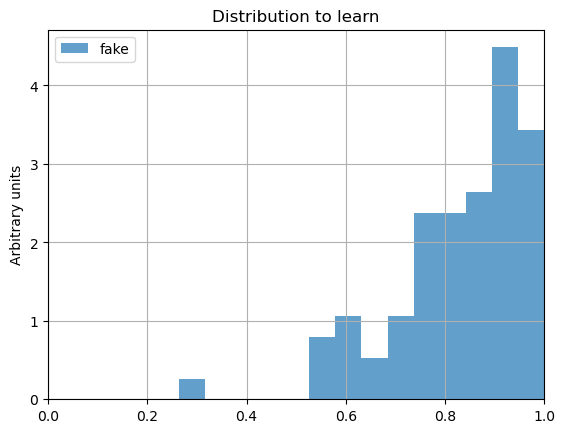

Epoch: 15 - Current Learning Rate: 1e-06
====> Epoch: 15 Average training (validation) loss: -1.1378 (-1.1329)
Epoch: 16 - Current Learning Rate: 1e-06
====> Epoch: 16 Average training (validation) loss: -1.1440 (-1.1373)


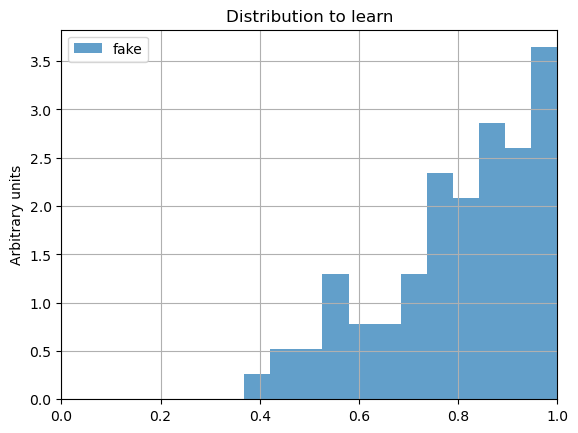

Epoch: 17 - Current Learning Rate: 1e-06
====> Epoch: 17 Average training (validation) loss: -1.1420 (-1.1374)
Epoch: 18 - Current Learning Rate: 1e-06
====> Epoch: 18 Average training (validation) loss: -1.1460 (-1.1507)


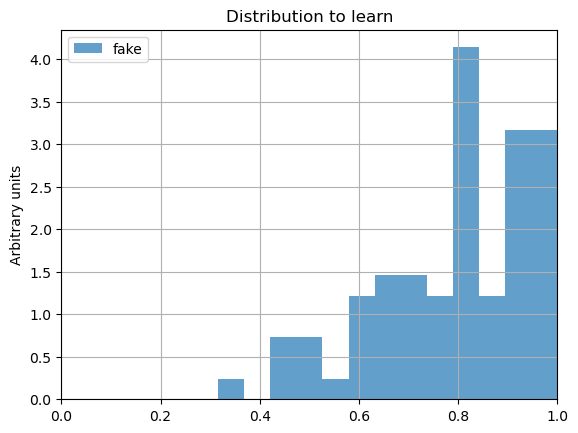

KeyboardInterrupt: 

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = 1
latent_dim = 50
hidden_dim = 100

beta = 1

model = CVAE(input_dim, latent_dim, label_dim, hidden_dim).to(device)
#model.apply(initialize_weights) # Xe weights

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5)


early_stopping = EarlyStopping(patience=20, verbose=False)

dummy = pd.DataFrame()

def generate_samples(model, z, labels):
    decoder = model.decoder
    recon_mu, recon_logvar = decoder(z, labels)
    recon_var = torch.exp(recon_logvar)
    samples = recon_mu + torch.randn_like(recon_var) * torch.sqrt(recon_var)
    return samples

def train(epoch):
    model.train()
    train_loss = 0
    
    stop = False
    for batch_idx, (data, labels) in enumerate(train_loader):
        assert not torch.isnan(data).any(), "Input features contain NaNs"
        assert not torch.isnan(labels).any(), "Labels contain NaNs"
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #recon_batch, mu, log_var = model(data, labels)
        #loss = loss_function(recon_batch, data, mu, log_var, beta=beta)
        recon_mu, recon_logvar, mu, log_var = model(data, labels)
        #recon_mu, mu, log_var = model(data, labels)

        assert not torch.isnan(mu).any(), "Encoder mean contains NaNs"
        assert not torch.isnan(log_var).any(), "Encoder variance contains NaNs"
        assert not torch.isnan(recon_mu).any(), "Decoder mean contains NaNs"
        assert not torch.isnan(recon_logvar).any(), "Decoder variance contains NaNs"

        loss = loss_function(recon_mu, recon_logvar, data, mu, log_var, beta=beta)
        #loss = loss_function(recon_mu, None, data, mu, log_var, beta=beta)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % 2 == 0:
        #    print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_train_loss = train_loss / len(train_loader.dataset)
    
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No gradients needed
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            #recon, mu, log_var = model(data, labels)
            #loss = loss_function(recon, data, mu, log_var, beta=beta)
            recon_mu, recon_logvar, mu, log_var = model(data, labels)
            loss = loss_function(recon_mu, recon_logvar, data, mu, log_var)

            #recon_mu, mu, log_var = model(data, labels)
            #loss = loss_function(recon_mu, None, data, mu, log_var, beta=beta)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    if epoch %1 == 0:
        print(f'Epoch: {epoch} - Current Learning Rate: {current_lr}')
        print(f'====> Epoch: {epoch} Average training (validation) loss: {avg_train_loss:.4f} ({avg_val_loss:.4f})')
    if epoch %2 == 0:
        #print(recon_mu)
        generate_and_plot(dummy, model, [250, 100], latent_dim, 100)
        #generate_and_plot(dummy, model, [220, 50], latent_dim, 100)
    
    scheduler.step(avg_val_loss)  

    
    # Call to the early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        stop = True

    return avg_train_loss, avg_val_loss, current_lr, stop



num_epochs = 10000
train_losses, val_losses, learning_rate = [], [],  []
for epoch in range(1, num_epochs + 1):
    t_loss, v_loss, lr, stop = train(epoch)        
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    learning_rate.append(lr)
    
    #if epoch % 5 == 0:  # Generate images every 2 epochs
    #    generate_images(model, epoch)
    if stop: break



In [ ]:
model.eval()

labels = [1000,500]

n_events = 100
z = torch.randn(n_events, latent_dim).to(device)  # Adjust latent_dim to 30
label_tensor = torch.tensor(np.tile(labels, n_events).reshape(n_events, 2)).to(device)
                              
# Generate signal
signal = model.decoder(z, label_tensor).to("cpu").detach().numpy()
print(signal)

generate_and_plot(dummy, model, labels, latent_dim, 100)

In [ ]:
plt.plot(range(len(train_losses) -1), train_losses[1:], label="train set", color="green")
plt.plot(range(len(val_losses) -1), val_losses[1:], label="validation set", color="blue")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.yscale('log')

plt.legend()
plt.show()

plt.plot(range(len(learning_rate)), learning_rate, label="Learning rate", color="green")

plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.title("Learning rate")
plt.yscale('log')

plt.legend()
plt.show()


In [17]:
def plot_generated(df, signal, real_mX, real_mS):

    custom = np.linspace(0, 1, 50)

    filtered_df = df[(df['real_mX'] == real_mX) & (df['real_mS'] == real_mS)]

    plt.hist(filtered_df["PNN_score"][:len(signal)], alpha=0.7, density=True, bins=custom, label = "real")
    plt.hist(signal, alpha=0.7, density=True, bins=custom, label = "fake")
    plt.xlabel('PNN('+str(int(real_mX))+", "+str(int(real_mS))+')')
    plt.ylabel('Arbitrary units')
    plt.title('Distribution to learn')
    plt.xlim(0, 1)  # Force x-axis range to [0, 1]
    plt.legend()
    plt.grid(True)
    plt.show()


z = torch.randn(100, latent_dim).to(device)  # Adjust latent_dim to 30labels = torch.tensor(np.tile(labels, n_events).reshape(n_events, 2)).to(device)
                              
    # Generate signal
signal = model.decoder(z, labels).to("cpu").detach().numpy()

plot_generated(data, generated_signal, 185, 30)

IndentationError: unexpected indent (1911644948.py, line 21)